Давайте познакомимся с одним из способов выделения трендовой и сезонной компонент ряда и визуального анализа шума.

In [1]:
# https://drive.google.com/file/d/1i2WS6RQo32syz1DUIPdo5bdaSM_XcJq_/view
!gdown 1i2WS6RQo32syz1DUIPdo5bdaSM_XcJq_

Downloading...
From: https://drive.google.com/uc?id=1i2WS6RQo32syz1DUIPdo5bdaSM_XcJq_
To: /content/train.zip
100% 838M/838M [00:11<00:00, 70.4MB/s]


In [2]:
!unzip train.zip

Archive:  train.zip
  inflating: train.csv               


In [3]:
!cat train.csv | grep ",25," > train25.csv && du -h train25.csv

79M	train25.csv


In [4]:
! head -n 1 train.csv

id,date,store_nbr,item_nbr,unit_sales,onpromotion


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

df = pd.read_csv('train25.csv', header=None) # считываем датасет
df.columns = (['id','date','store_nbr','item_nbr','unit_sales','onpromotion'])
# df.columns = (['Month','Pass']) # заменяем название столбца '#Passenger' на 'Pass' чтобы избежать путаницы с комментариями
df.head(2) # смотрим на первые несколько строчек

<ipython-input-5-04a57b5bae1f>:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train25.csv', header=None) # считываем датасет


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN


In [6]:
df = df[df.store_nbr==25].groupby("date")['unit_sales'].sum().reset_index()
df.sample()

,date,unit_sales
49,2013-02-19,3655.293


In [7]:
# приводим индексы к стандарту pd.Datetime, чтобы потом это можно было скормить seasonal_decompose
df = df.set_index(pd.DatetimeIndex(df['date']))
df.head(2) # смотрим на результат

,date,unit_sales
date,,
2013-01-01,2013-01-01,2511.619
2013-01-02,2013-01-02,5316.224


In [8]:
 # замечаем, что т.к. у нас теперь есть индекс Month, нам больше не нужен столбец Month, который его дублирует
df.drop(['date'], axis = 1, inplace = True)
df.head(2) # снова проверяем, что все в порядке. вообще проверять данные на каждом шаге кода - хорошая привычка

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224


In [9]:
len(df)

1618

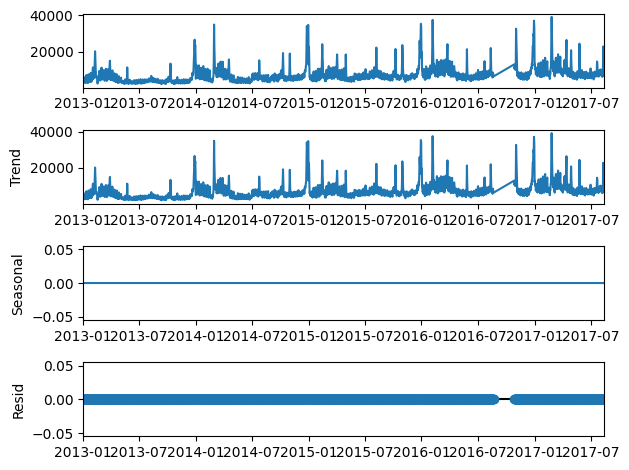

In [10]:
# применяем seasonal_decompose
# эта функция разложит ряд на трендовую, сезонную и шумовую составляющие
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as pyplot
decomposition = seasonal_decompose(df, model='additive', period=1)
decomposition.plot()
pyplot.show() # любуемся результатом

In [11]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось
len(trend_part), len(seasonal_part), len(residual_part)

(1618, 1618, 1618)

In [12]:
# посмотрим повнимательнее на остатки в начале ряда
residual_part.head()

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
Name: resid, dtype: float64

In [13]:
# посмотрим повнимательнее на остатки в конце ряда
residual_part.tail()

date
2017-08-11    0.0
2017-08-12    0.0
2017-08-13    0.0
2017-08-14    0.0
2017-08-15    0.0
Name: resid, dtype: float64

In [14]:
# в конце и в начале стоят значения NaN. Это связано с особенностями алгоритма seasonal_decompose
# если мы хотим далее анализировать остатки, необходимо избавиться от этих некорректных значений
residual_part = residual_part.dropna()
residual_part.head()

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
Name: resid, dtype: float64

In [15]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.858992665318184
p-value:  4.188394192907693e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


In [16]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()
train_test_groups = tscv.split(df.unit_sales)
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 273 TEST size: 269
TRAIN size: 542 TEST size: 269
TRAIN size: 811 TEST size: 269
TRAIN size: 1080 TEST size: 269
TRAIN size: 1349 TEST size: 269


In [17]:
df_mean5 = df.unit_sales.rolling(window=5).apply(np.mean)
df_std5 = df.unit_sales.rolling(window=5).apply(np.std)

rolling_mean  = df.unit_sales.rolling(window=30).apply(np.mean)
rolling_std = df.unit_sales.rolling(window=30).apply(np.std)

upper = rolling_mean + 3 * rolling_std
lower = rolling_mean - 3 * rolling_std

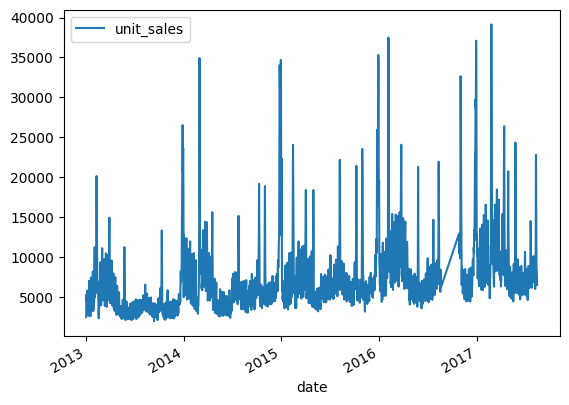

In [20]:
df.plot()
pyplot.show()

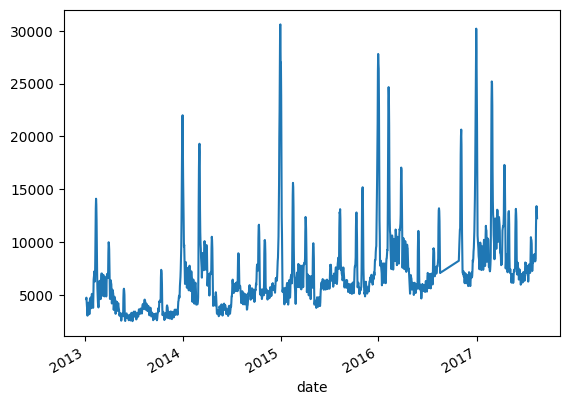

In [21]:
df_mean5.plot()
pyplot.show()

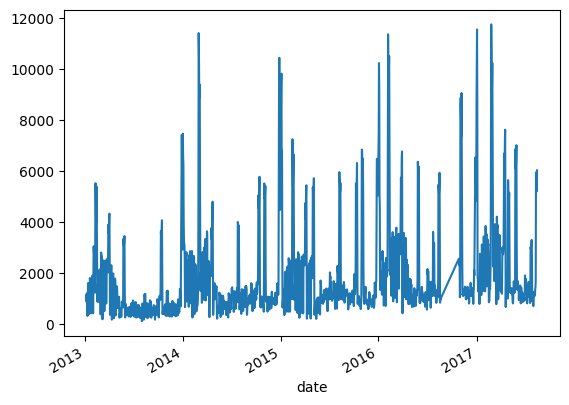

In [22]:
df_std5.plot()
pyplot.show()

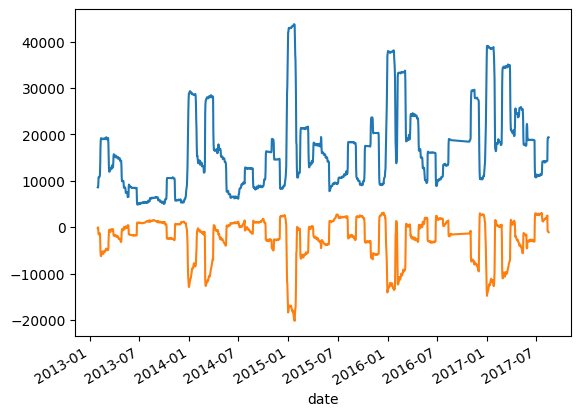

In [23]:
upper.plot()
lower.plot()
pyplot.show()

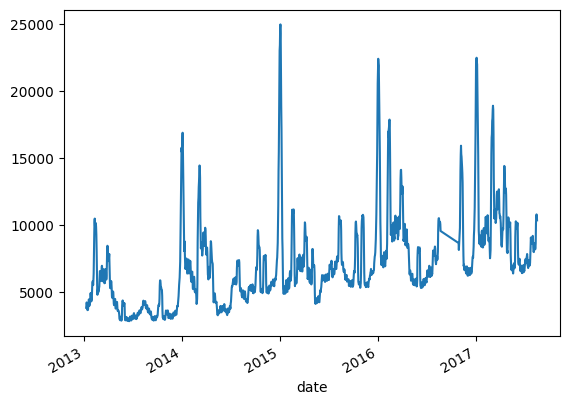

In [25]:
df_mean10 = df.unit_sales.rolling(window=10).apply(np.mean)
df_mean10.plot()
pyplot.show()

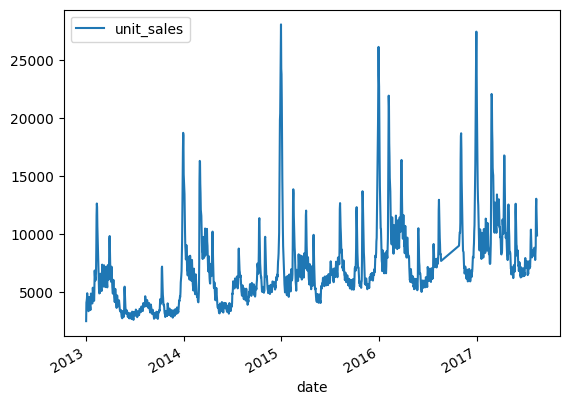

In [28]:
df_exp7 = df.unit_sales.to_frame().ewm(span=7).mean() #rolling(span=7).apply(np.exp)

# reliance = reliance['Close'].to_frame()

df_exp7.plot()
pyplot.show()

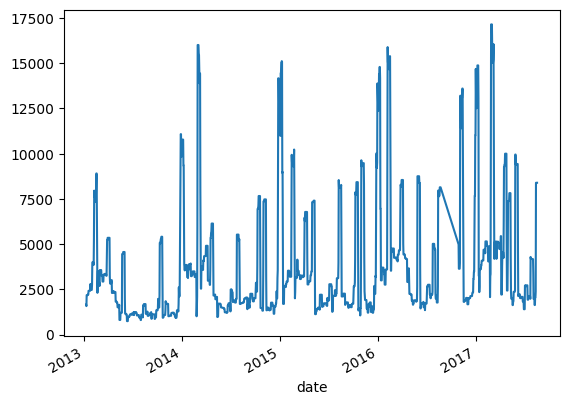

In [29]:
rolling_max  = df.unit_sales.rolling(window=10).apply(np.max)
rolling_min = df.unit_sales.rolling(window=10).apply(np.min)

rolling_avg10 = (rolling_max - rolling_min) /2
rolling_avg10.plot()
pyplot.show()

In [41]:
df_mean50 = df.unit_sales.rolling(window=50).apply(np.mean)
df_exp10 = df.unit_sales.to_frame().ewm(span=10).mean()
inter = np.sign(df_mean50 - df_exp10).diff()
inter.drop_duplicates().index

DatetimeIndex(['2013-01-01'], dtype='datetime64[ns]', name='date', freq=None)

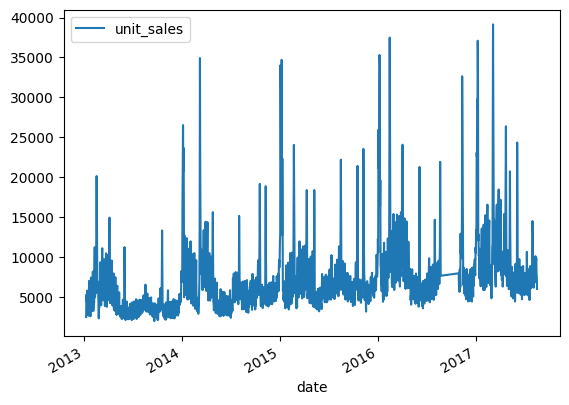

In [43]:
df_lag7 = df.shift(7)
df_lag7.plot()
pyplot.show()

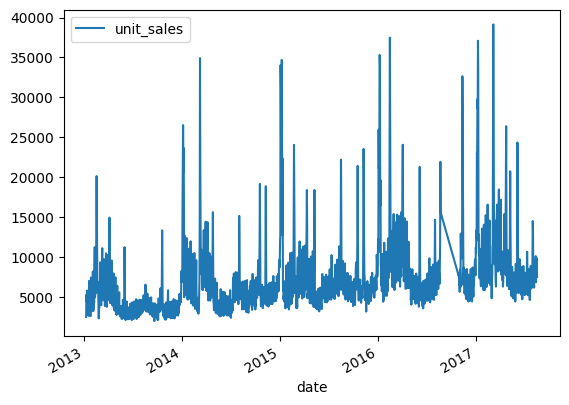

In [44]:
df_lag8 = df.shift(8)
df_lag8.plot()
pyplot.show()

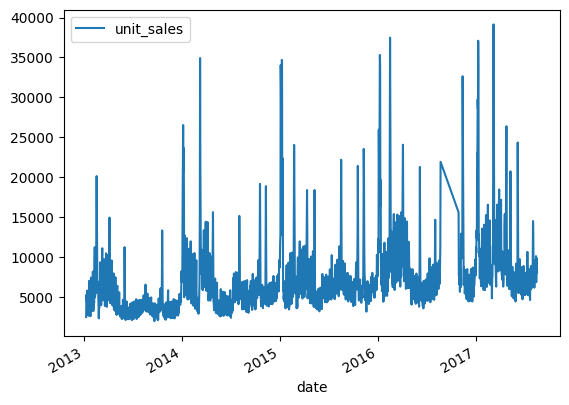

In [45]:
df_lag9 = df.shift(9)
df_lag9.plot()
pyplot.show()

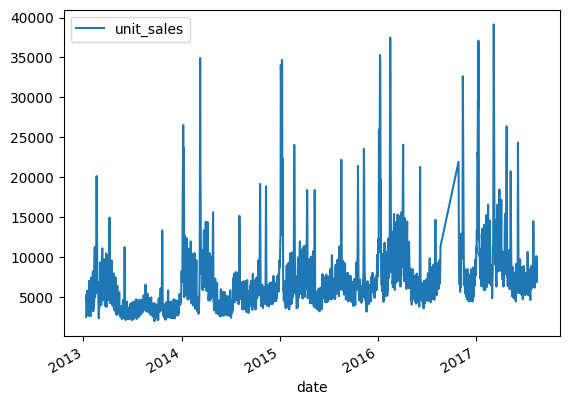

In [46]:
df_lag10 = df.shift(10)
df_lag10.plot()
pyplot.show()